# "Face Recognition"
> "Face detection & Face recognition using FaceNet model"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

### Face Recognition : Overview
Here I trained Face Recognition model on 5 boys & 3 girls.  We can divide training process for in follwing steps: 
1.   Data Augmentation : I took 5 original images of 1 person & convert it into 30 images
2.   Face Detection : Detect faces using OpenCv's DNN "caffe" model & crop them
3.   Face Embeddings: Getting Facial Landmarks of shape (128,1) from cropped faces using FaceNet model. 
4.   Face Classification: Now Using this Facial landmarks we can train our model using any classification algorithm, I have used SVM classifier.





In [3]:

# import the necessary packages
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import argparse
import cv2
import time
import matplotlib.pyplot as plt
import os
from numpy import asarray
from PIL import Image
from numpy import savez_compressed
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import psutil
from scipy import ndimage
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

#enter main directory path
main_dir_path = "/content/drive/MyDrive/FaceNet/Face Recogntion with Detailed"

import warnings
warnings.filterwarnings('ignore')

### Exploring Data-set
* you can find 5-img_data.npz file [here](https://drive.google.com/file/d/1-Es9i4Wd-WAZ66QdKqDQBKsRQYWa3Qow/view?usp=sharing)

In [13]:
data = load(main_dir_path+"/5-img_data.npz")
X_train, X_test,y_train,y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"labels:{np.unique(y_train)}")

X_train shape:(40, 300, 300, 3)
X_test shape:(192, 300, 300, 3)
labels:['Isha' 'Karm' 'Lance' 'Mahisha' 'Malav' 'Nency' 'Rutvik' 'Smit']


 Usually we have 80-20 distribution of train-test but here it
is reversed!<br>
Here I took 5 train image & 22-27 test images per class, because I want to make my model less hungry of data & test on more data 


### Data Augmentation
I did data augmentation with following variants:


1.   Rotate image with 20 degree
2.   Rotate image with -20 degree
3.   Flip Original Image
4.   High brightness of flipped Image
5.   High Contrast of original Image







In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
def dataAugmentation(original):
    augmented = []
    augmented.append(original)
    # horizontal flip
    flipped = cv2.flip(original, 1)
    augmented.append(flipped)
    # rotate clockwise & counterclock wise
    augmented.append(ndimage.rotate(original, -20, (1, 0)))
    augmented.append(ndimage.rotate(original, 20, (1, 0)))
    # brightness
    alpha_1, alpha_2 = 1, 1.5
    beta_1, beta_2 = 50, 0
    augmented.append(cv2.convertScaleAbs(flipped, alpha=alpha_1, beta=beta_1))
    # contrast
    augmented.append(cv2.convertScaleAbs(original, alpha=alpha_2, beta=beta_2))
    return augmented


In [11]:
X_aug_train,y_aug_train = [],[]
#Data Augmentation of traing data set
for img_arr,label in zip(X_train,y_train):
  augmented = asarray(dataAugmentation(img_arr))
  for each in augmented:
    X_aug_train.append(each)
  y_aug_train.extend([label]*len(augmented))

#coverting in numpy array
X_aug_train = asarray(X_aug_train)
y_aug_train = asarray(y_aug_train) 

#### Example Of Data Augmentation

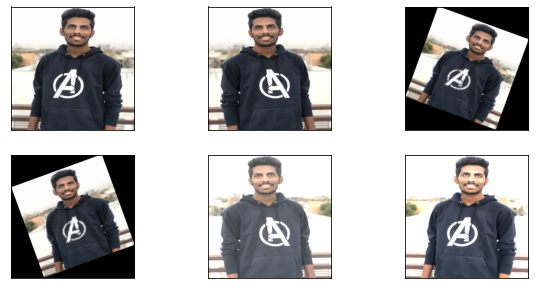

In [18]:
#Augmented Images
augmented = dataAugmentation(X_train[1])
fig,axes = plt.subplots(2,3,figsize=(10,6))
ind = 0
for i in range(2):
  for j in range(3):
    axes[i][j].imshow(augmented[ind].astype(np.uint8))
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)
    ind+=1


### Face Detection

In [33]:
#load pretrained model of dnn(deep neural network)
def load_face_det_model():
    print("[INFO] loading model...")
    model = cv2.dnn.readNetFromCaffe(os.path.join(main_dir_path,"deploy.prototxt.txt"), os.path.join(main_dir_path,"res10_300x300_ssd_iter_140000.caffemodel"))
    if model:
        print("model loaded")
        return model

def extract_faces(model,image_arr,names,required_size=(160,160)):
    #to store cropped faces
    cropped = []
    #to store labels/person names
    labels = []

    print(f"Images shape:{image_arr.shape}")

    for image,name in zip(image_arr,names):
        #image preprocessing like mean substraction
        blob = cv2.dnn.blobFromImage(image, 1.0,(300, 300), (104.0, 177.0, 123.0))
      
        # pass the blob through the network and obtain the detections and
        # predictions
        model.setInput(blob)
        try:
            detections = model.forward()
        except:
            print("skip {} due to model error".format(label))
            continue

        '''
        detection.shape =  (1, 1, 200, 7)
        7 columns:

        3rd column = confidence of pixel
        4th column = (startX)/width
        5th column = (startY)/height
        6th column = (endX)/width
        7th column = (endY)/height

        '''
       
        height, width = image.shape[:2]
     
        #maximum of all detections -> detect most accurate one face
        '''
        This model detecting maximum 200 faces from single image
        However, here I considerd only 1 detection per image by 
        taking maximum of all confidences
        '''
        confidence = detections.max(axis=2)[0][0][2]
        #get index of Max confidence
        arg = detections.argmax(axis=2)[0][0][2]

        #take last axis
        each = detections[0][0][arg]

        #if confidence is low then may be that is not face
        if confidence >0.5:
            try:
                
                #getting factors
                startX_factor, startY_factor, endX_factor, endY_factor = each[3:]
                
                #gatting original dimensions of face
                startX, startY, endX, endY = int(startX_factor*width), int(startY_factor*height), int(endX_factor*width), int(endY_factor*height)
             
                #cropp image
                crop = image[startY:endY,startX:endX]

                #resize face to (160,160,3)
                crop_img = array_to_img(crop)
                crop_img = crop_img.resize(required_size)
                face = img_to_array(crop_img)
               
                #append it in croppped list
                cropped.append(face)
                labels.append(name)
  
            except:
                #incase complete face is not in image
                print("face is out of frame -> not detected in",name)
        else:
            print("low confidence:{},face not detected in {}".format(confidence,name))
    print("{}/{} faces detected".format(len(cropped),len(image_arr)))
    return asarray(cropped),asarray(labels)


In [34]:
face_detection_model = load_face_det_model()
X_faces_train,y_faces_train = extract_faces(face_detection_model,X_aug_train,y_aug_train) 


[INFO] loading model...
model loaded
Images shape:(240,)
low confidence:0.3545130789279938,face not detected in ['Rutvik']
low confidence:0.49305716156959534,face not detected in ['Malav']
238/240 faces detected


So Our Model can detect 238 faces from 240 augmented images.

### Face Embeddings:


*   I used FaceNet model to get Facial Landmarks
*   FaceNet model takes cropped faces of size (160,160) as an input.
* you can find facenet_keras.h5 [here](https://drive.google.com/file/d/1a_cGR9wHsLpMxruFcFY4ZF56OZWFaKPt/view?usp=sharing)

In [35]:
def get_embeddings(model,data):
    embs = []
    for face_pixels in data:
      face_pixels = face_pixels.astype('float32')
      #Z-score normalization
      mean = face_pixels.mean()
      std = face_pixels.std()
      face_pixels = (face_pixels-mean)/std 
      
      #convert in required dimension for facenet model
      samples = expand_dims(face_pixels,axis=0)
      
      #get (128,1) embeddings
      emb = model.predict(samples)
      embs.append(emb[0])
    return asarray(embs)

In [36]:
facenet_model = load_model(main_dir_path+"/facenet_keras.h5")
X_embs_train = get_embeddings(facenet_model,X_faces_train)
X_embs_train.shape

(238, 128)

### SVM Classifer for Face Classification

After getting (128,1) embeddings for each image, we will train SVM model by taking embedding as a features. It consists of follwing steps:

1.   Normalized Training data using Normalizer()
2.   We have target variables in String format, so we must convert it using  LabelEncoder()



In [37]:
def load_face_classifier_with_labels(data):

    trainX, trainy = data['Xtrain'], data['ytrain']
    print('Dataset: train=%d' % (trainX.shape[0]))

    #l-2 normalization
    encoder = Normalizer()
    trainX = encoder.transform(trainX)
   
    #conver string labels into numeric
    label_encoder = LabelEncoder()
    label_encoder.fit(trainy)
    trainy = label_encoder.transform(trainy)

    #load SVM Classifier
    svm_model = SVC(kernel='linear',probability=True)
    #training
    svm_model.fit(trainX,trainy)

    #prediction
    train_pred = svm_model.predict(trainX)

    #convert numeric labels to original String labels    
    labels = label_encoder.inverse_transform(trainy)

    #training accuracy score
    print("train accuracy:",accuracy_score(trainy,train_pred))
   
    return (svm_model,label_encoder,labels)

In [38]:
data = dict()
data['Xtrain'] = X_embs_train
data['ytrain'] = y_faces_train

svm_model, label_encoder, labels = load_face_classifier_with_labels(data)

Dataset: train=238
train accuracy: 1.0


### Testing on Test Dataset

In [41]:
#extract faces
X_faces_test,y_faces_test = extract_faces(face_detection_model,X_test,y_test)

Images shape:(192, 300, 300, 3)
low confidence:0.1232241541147232,face not detected in ['Rutvik']
face is out of frame -> not detected in ['Isha']
face is out of frame -> not detected in ['Isha']
low confidence:0.15818965435028076,face not detected in ['Isha']
low confidence:0.1319667547941208,face not detected in ['Isha']
face is out of frame -> not detected in ['Mahisha']
face is out of frame -> not detected in ['Mahisha']
face is out of frame -> not detected in ['Mahisha']
184/192 faces detected


Face is Not detected in some images because whole face is not in an image.

In [43]:
#getting embeddings
X_embs_test = get_embeddings(facenet_model,X_faces_test)
y_embs_test = y_test_faces

In [45]:
#Preprocessing for SVM classifier
norm = Normalizer()
testX = norm.transform(X_embs_test)
testy = label_encoder.transform(y_faces_test)

#predict
y_pred = svm_model.predict(testX)
print(f"Test Accuracy={accuracy_score(y_pred,testy)}")

Test Accuracy=0.9945652173913043


### Visualizing Face-prints or embeddings
Here I visualized clusters of Face Embeddings of 8 persons (test dataset) using Principle Component Analysis.

In [142]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

trainX, trainy = X_test_embs, y_test_embs

encoder = Normalizer()
trainX = encoder.transform(trainX)
#trainX = StandardScaler().fit_transform(trainX)
pca = PCA(n_components=2)

principle_comp = pca.fit_transform(trainX)
df = pd.DataFrame(principle_comp)
df[2] = trainy
labels = df[2].unique()
colors = ["red","blue","black","yellow","orange","green","purple","gray"]
labels

array(['Rutvik', 'Karm', 'Nency', 'Malav', 'Lance', 'Smit', 'Isha',
       'Mahisha'], dtype=object)

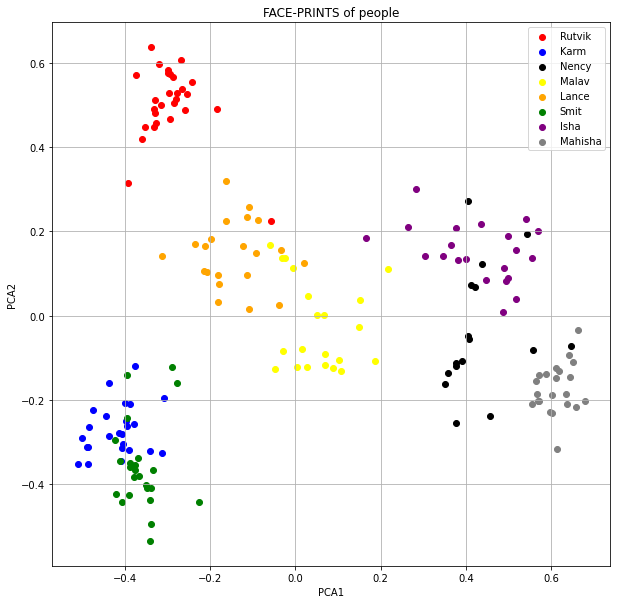

In [143]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title("FACE-PRINTS of people")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
for label,color in zip(labels,colors):
    ax.scatter(df[df[2] == label][0],df[df[2] == label][1],c=color)
ax.grid()
ax.legend(labels)

### Try Your Own Image

In [164]:
def try_your_own_image(path):
  image = img_to_array(load_img(path))
  image = expand_dims(image,0)
  print(f"image shape:{image.shape}")
  face,label = extract_faces(face_detection_model,image,asarray([""]))
  print(f"face shape:{face.shape}")
  embs = expand_dims(get_embeddings(facenet_model,face[0]),0)
  print(f"embs shape:{embs.shape}")
  pred = svm_model.predict(embs)
  prob = max(svm_model.predict_proba(embs)[0])
  print(label_encoder.inverse_transform(pred),prob)


In [165]:
try_your_own_image("/content/drive/MyDrive/FaceNet/Face Recogntion with Detailed/IMG_20210413_181124.jpg")

image shape:(1, 2592, 1944, 3)
(1, 2592, 1944, 3)
(1,)
1/1 faces detected
face shape:(1, 160, 160, 3)
embs shape:(1, 128)
['Karm'] 0.9999997501792055
